# Optimal interpolation module

Optimal interpolation is a tool that allows combining a spatially distributed field (i.e. the "background field") with point observations in such a way that the entire field can be adjusted according to deviations between the observations and the field at the point of observations. For example, it can be used to combine a field of reanalysis precipitation (e.g. ERA5) with observation records, and thus adjust the reanalysis precipitation over the entire domain in a statistically optimal manner. 

This page demonstrates how to use `xhydro` to perform optimal interpolation using field-like simulations and point observations for hydrological modelling. In this case, the background field is a set of outputs from a distributed hydrological model and the observations correspond to real hydrometric stations. The aim is to correct the background field (i.e. the distributed hydrological simulations) using optimal interpolation, as in Lachance-Cloutier et al (2017).

*Lachance-Cloutier, S., Turcotte, R. and Cyr, J.F., 2017. Combining streamflow observations and hydrologic simulations for the retrospective estimation of daily streamflow for ungauged rivers in southern Quebec (Canada). Journal of hydrology, 550, pp.294-306.*

In [2]:
import datetime as dt
from functools import partial
from pathlib import Path
from zipfile import ZipFile

import numpy as np
import pandas as pd
import pooch
import xarray as xr

import xhydro.optimal_interpolation.compare_result as cr
import xhydro.optimal_interpolation.optimal_interpolation_fun as opt
from xhydro.optimal_interpolation.ECF_climate_correction import general_ecf

/home/richard/miniconda3/envs/xhydro/lib/python3.11/site-packages/clisops/core/regrid.py:42: UserWarning: xarray version >= 2023.03.0 is not supported for regridding operations with cf-time indexed arrays. Please use xarray version < 2023.03.0. For more information, see: https://github.com/pydata/xarray/issues/7794.
  warnings.warn(


## Data requirements

The current implementation of the optimal interpolation method is limited to streamflow simulations, and as such, has some specific data requirements. Here we explore the contents of a complete input file, and we will add details a bit later. Start by importing some test data from the `xhydro-testdata` repository:

In [3]:
# Get data with pooch
test_data_path = pooch.retrieve(
    url="https://github.com/hydrologie/xhydro-testdata/raw/main/data/optimal_interpolation/OI_data_corrected.zip",
    known_hash="md5:acdf90b78b53595eb97ff0e84fc07aa8",
)

# Extract to a cache path.
directory_to_extract_to = Path(test_data_path).parent
with ZipFile(test_data_path, "r") as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

# Read-in all the files and set to paths that we can access later.
flow_obs_info_file = directory_to_extract_to / "A20_HYDOBS_TEST_corrected.nc"
flow_sim_info_file = directory_to_extract_to / "A20_HYDREP_TEST_corrected.nc"
corresponding_station_file = directory_to_extract_to / "station_correspondence.nc"
selected_station_file = (
    directory_to_extract_to / "stations_retenues_validation_croisee.csv"
)

We now have 4 files:
- flow_obs_info_file: The dataset file (.nc) that contains the point observations and station metadata.
- flow_sim_info_file: The dataset file (.nc) that contains the background field simulations, including simulated station metadata.
- corresponding_station_file: The dataset file (.nc) that links the station identifiers between observations and simulated stations. This is necessary because observed stations have "real world" identifiers and distributed simulations are often coded or numbered sequentially. However, we need to be able to find which of the background field stations (simulation points) correspond to each real-world station.
- selected_station_file: The list of stations from the observation set that we wish to use (thus discarding the others from the flow_obs_info_file set).

### a) From a list of coordinates
In this scenario, we select two pour points, with each one representing the outlet for the watersheds of Lac Saint-Jean and the Ottawa River, respectively.

In [19]:
lng_lat = [
    (-69.81971, 48.14720),  # Lac Saint-Jean watershed
    (-74.393438, 45.572442),  # Ottawa river watershed
]

### b) From markers on a map

Instead of using a list, a more interactive approach is to directly select outlets from the existing map ``m``. The following image illustrates the process of selecting pour points by dragging markers to the desired locations on the map.

![test](../../docs/_static/_images/example_draw_marker.png)

The next cell is only useful for the documentation as it simulates a user selecting an outlet from the map `m`. You should instead remove this code and interact with the map in object `m` as shown above by positionning markers at sites of interest

In [20]:
m.draw_features = [
    {
        "type": "Feature",
        "properties": {},
        "geometry": {"type": "Point", "coordinates": [-73.118597, 46.042467]},
    }
]  # Richelieu watershed

After selecting points using either approach a) or b), or a combination of both, we can initiate the watershed delineation calculation.

In [21]:
gdf = xhgis.watershed_delineation(coordinates=lng_lat, map=m)
gdf

,HYBAS_ID,Upstream Area (sq. km).,geometry,category,color
0,7120034330,87595.8,"POLYGON ((-74.37864 48.88141, -74.37452 48.886...",3,#41b6c4
1,7120398781,144026.8,"POLYGON ((-80.07991 46.77860, -80.08529 46.782...",5,#081d58
2,7120382860,23717.7,"POLYGON ((-73.77437 43.36757, -73.77557 43.388...",1,#ffffd9


The outcomes are stored in a GeoPandas `gpd.GeoDataFrame` (`gdf`) object, allowing us to save our polygons in various common formats such as an ESRI Shapefile or GeoJSON. If a map ``m`` is present, the polygons will automatically be added to it. If you want to visualize the map, simply type ``m`` in the code cell to render it. If displaying the map directly is not compatible with your notebook interpreter, you can utilize the following code to extract the HTML from the map and plot it:

In [22]:
m.zoom_to_gdf(gdf)

### c) From [xdatasets](https://github.com/hydrologie/xdatasets)

Automatically delineating watershed boundaries is a valuable tool in the toolbox, but users are encouraged to utilize official watershed boundaries if they already exist, instead of creating new ones. This functionality fetches a list of basins from [xdatasets](https://github.com/hydrologie/xdatasets) supported datasets, and upon request, [xdatasets](https://github.com/hydrologie/xdatasets) provides a `gpd.GeoDataFrame` containing the precalculated boundaries for these basins. Currently, the following watershed sources are available as of today.:

| Source                                                                                                                                                             | Dataset name   |
|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------|
| [DEH](https://www.cehq.gouv.qc.ca/atlas-hydroclimatique/stations-hydrometriques/index.htm)                                                                         | deh_polygons   |
| [HYDAT](https://www.canada.ca/en/environment-climate-change/services/water-overview/quantity/monitoring/survey/data-products-services/national-archive-hydat.html) | hydat_polygons |
| [HQ](https://www.hydroquebec.com/r)                                                                                                                                | hq_polygons    |


In [23]:
gdf = xd.Query(
    **{
        "datasets": {
            "deh_polygons": {
                "id": ["031*", "0421*"],
                "regulated": ["Natural"],
            }
        }
    }
).data.reset_index()

gdf

,Station,Superficie,geometry
0,031501,21.868620,"POLYGON ((-72.47379 46.23340, -72.46888 46.228..."
1,031502,15.708960,"POLYGON ((-72.50127 46.21216, -72.50086 46.213..."
2,042103,579.479614,"POLYGON ((-78.49014 46.64514, -78.49010 46.645..."


## Extract watershed properties

After obtaining our watershed boundaries, we can extract valuable properties such as geographical information, land use classification and climatological data from the delineated watersheds.

### a) Geographical watershed properties
Initially, we extract geographical properties of the watershed, including the perimeter, total area, Gravelius coefficient and basin centroid. It's important to note that this function returns all the columns present in the provided `gpd.GeoDataFrame` argument.

In [24]:
xhgis.watershed_properties(gdf)

,Station,Superficie,area,perimeter,gravelius,centroid
0,031501,21.868620,2.186862e+07,27186.996845,1.640007,"(-72.48631199105834, 46.22277542928622)"
1,031502,15.708960,1.570896e+07,20263.293021,1.442220,"(-72.47966677792694, 46.21359517038631)"
2,042103,579.479614,5.794796e+08,283765.058390,3.325331,"(-78.37036445281987, 46.48287117609677)"


For added convenience, we can also retrieve the same results in the form of an `xarray.Dataset`:

In [25]:
xhgis.watershed_properties(
    gdf[["Station", "geometry"]], unique_id="Station", output_format="xarray"
)

<xarray.Dataset> Size: 120B
Dimensions:    (Station: 3)
Coordinates:
  * Station    (Station) object 24B '031501' '031502' '042103'
Data variables:
    area       (Station) float64 24B 2.187e+07 1.571e+07 5.795e+08
    perimeter  (Station) float64 24B 2.719e+04 2.026e+04 2.838e+05
    gravelius  (Station) float64 24B 1.64 1.442 3.325
    centroid   (Station) object 24B (-72.48631199105834, 46.22277542928622) ....

### b) Land-use classification
Land use classification is powered by the Planetary Computer's STAC catalog. It uses the `10m Annual Land Use Land Cover` dataset by default ("io-lulc-9-class"), but other collections can be specified by using the collection argument. 

In [26]:
df = xhgis.land_use_classification(gdf, unique_id="Station")
df

  0%|          | 0/3 [00:00<?, ?it/s]

,pct_crops,pct_built_area,pct_trees,pct_rangeland,pct_water,pct_bare_ground,pct_flooded_vegetation,pct_snow/ice
Station,,,,,,,,
031501,0.776151,0.030159,0.191648,0.002042,0.000000,0.000000,0.000000,0.000000e+00
031502,0.755217,0.023085,0.218869,0.002830,0.000000,0.000000,0.000000,0.000000e+00
042103,0.000000,0.000101,0.863602,0.026126,0.109987,0.000021,0.000162,3.780111e-07


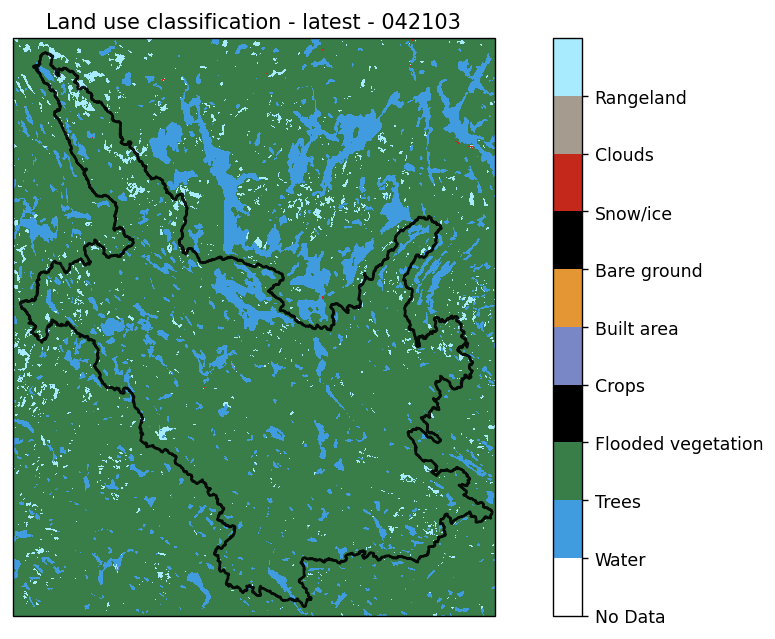

In [27]:
ax = xhgis.land_use_plot(gdf, unique_id="Station", idx=2)

### c) Climate indicators
The step of extracting climatic indicators is the most complex. Indeed, to accomplish this, access to a weather dataset for the various watersheds within our `gdf` object is required. Fortunately, `xdatasets` precisely facilitates such operations. Indeed, `xdatasets` allows extracting from a gridded dataset all the pixels contained within a watershed while respecting the weighting of the watershed intersecting each pixel.Subsequently, the function `get_yearly_op`, built upon the `xclim` library, offers impressive flexibility in defining indicators tailored to the user's needs.

To initiate the process, we employ ERA5-Land reanalysis data spanning the period from 1981 to 2010 as our climatological dataset.

In [28]:
datasets = {
    "era5_land_reanalysis": {"variables": ["t2m", "tp", "sd"]},
}
space = {
    "clip": "polygon",  # bbox, point or polygon
    "averaging": True,
    "geometry": gdf,  # 3 polygons
    "unique_id": "Station",
}
time = {
    "start": "1981-01-01",
    "end": "2010-12-31",
    "timezone": "America/Montreal",
}

ds = xd.Query(datasets=datasets, space=space, time=time).data.squeeze()

0it [00:00, ?it/s]

Because the next few steps use [xclim](https://xclim.readthedocs.io/en/stable/index.html) under the hood, the dataset is required to be [CF-compliant](http://cfconventions.org/cf-conventions/cf-conventions.html). At a minimum, the `xarray.DataArray` used must follow these principles:

- The dataset needs a time dimension, usually at a daily frequency with no missing timesteps (NaNs are supported). If your data differs from that, you'll need to be extra careful on the results provided.
- If there is a spatial dimension, such as "``Station``" in the example below, it needs an attribute ``cf_role`` with ``timeseries_id`` as its value.
- The variable will at the very least need a ``units`` attribute, although other attributes such as ``long_name`` and ``cell_methods`` are also expected by `xclim` and warnings will be generated if they are missing.
- While this is not necessary for get_yearly_op, variable names should be one of those supported here for maximum compatibility.

The following code adds the missing attributes :

In [29]:
ds = ds.rename({"t2m": "tas", "tp": "pr", "sd": "snd"})
ds["tas"] = xclim.core.units.convert_units_to(
    ds["tas"], "degC"
)  # Convert from degK to degC
ds["tas"].attrs.update({"cell_methods": "time: mean"})

ds["pr"].attrs.update({"units": "m d-1", "cell_methods": "time: mean within days"})
ds["pr"] = xclim.core.units.convert_units_to(
    ds["pr"], "mm d-1"
)  # Convert from m/d to mm/d

ds["snd"].attrs.update({"units": "m", "cell_methods": "time: mean within days"})
ds["snd"] = xclim.core.units.convert_units_to(ds["snd"], "mm")  # Convert from m to mm
ds

<xarray.Dataset> Size: 21MB
Dimensions:  (time: 262968, Station: 3)
Coordinates:
  * time     (time) datetime64[ns] 2MB 1981-01-01 ... 2010-12-31T23:00:00
  * Station  (Station) object 24B '031501' '031502' '042103'
    source   <U20 80B 'era5_land_reanalysis'
Data variables:
    tas      (Station, time) float64 6MB -23.29 -23.28 -23.49 ... 2.389 2.339
    pr       (Station, time) float64 6MB 0.0 0.0 0.0 ... 0.003698 0.0006662
    snd      (Station, time) float64 6MB 55.07 55.07 55.07 ... 64.58 64.21 63.84

In the second step, we can define seasons using indexers that are compatible with ``xclim.core.calendar.select_time``. There are currently four accepted types of indexers:

- `month`, followed by a sequence of month numbers.

- `season`, followed by one or more of `‘DJF’`, `‘MAM’`, `‘JJA’`, and `‘SON’`.

- `doy_bounds`, followed by a sequence representing the inclusive bounds of the period to be considered (`'start'`, `'end'`).

- `date_bounds`, which is the same as above, but using a month-day (`'%m-%d'`) format.

Following this, we specify the operations we intend to calculate for each variable. The supported operations include `"max"`, `"min"`, `"mean"`, and `"sum"`.

In [30]:
timeargs = {
    "01": {"month": [1]},
    "02": {"month": [2]},
    "03": {"month": [3]},
    "04": {"month": [4]},
    "05": {"month": [5]},
    "06": {"month": [6]},
    "07": {"month": [7]},
    "08": {"month": [8]},
    "09": {"month": [9]},
    "10": {"month": [10]},
    "11": {"month": [11]},
    "12": {"month": [12]},
    "spring": {"date_bounds": ["02-11", "06-19"]},
    "summer_fall": {"date_bounds": ["06-20", "11-19"]},
    "year": {"date_bounds": ["01-01", "12-31"]},
}

operations = {
    "tas": ["max", "mean", "min"],
    "pr": ["sum"],
    "snd": ["mean"],
}

The combination of `timeargs` and `operations` through the Cartesian product yields a rapid generation of an extensive array of climate indicators.

In [31]:
ds_climatology = xr.merge(
    [
        get_yearly_op(ds, input_var=variable, op=op, timeargs=timeargs)
        for (variable, ops) in operations.items()
        for op in ops
    ]
)
ds_climatology

<xarray.Dataset> Size: 54kB
Dimensions:               (Station: 3, time: 30)
Coordinates:
  * Station               (Station) object 24B '031501' '031502' '042103'
    source                <U20 80B 'era5_land_reanalysis'
  * time                  (time) datetime64[ns] 240B 1981-01-01 ... 2010-01-01
Data variables: (12/75)
    tas_max_01            (Station, time) float64 720B 5.1 3.616 ... 3.161
    tas_max_02            (Station, time) float64 720B 13.23 1.781 ... 3.544
    tas_max_03            (Station, time) float64 720B 11.61 10.72 ... 12.78
    tas_max_04            (Station, time) float64 720B 19.4 20.66 ... 25.98
    tas_max_05            (Station, time) float64 720B 24.39 28.17 ... 32.24
    tas_max_06            (Station, time) float64 720B 29.32 28.33 ... 25.42
    ...                    ...
    snd_mean_10           (Station, time) float64 720B 0.3611 ... 0.4031
    snd_mean_11           (Station, time) float64 720B 4.29 2.369 ... 7.307
    snd_mean_12           (Station, time) float64 720B 44.07 5.757 ... 52.67
    snd_mean_spring       (Station, time) float64 720B 6.949 92.08 ... 33.31
    snd_mean_summer_fall  (Station, time) float64 720B 0.1345 0.1227 ... 0.7276
    snd_mean_year         (Station, time) float64 720B 14.36 47.45 ... 25.75
Attributes:
    cat:variable:          ('tas_max_01',)
    cat:xrfreq:            YS-JAN
    cat:frequency:         yr
    cat:processing_level:  indicators
    cat:id:

The same data can also be visualized as a `pd.DataFrame` as well : 

In [32]:
pd.set_option("display.max_rows", 100)
ds_climatology.mean("time").to_dataframe().T

Station,031501,031502,042103
source,era5_land_reanalysis,era5_land_reanalysis,era5_land_reanalysis
tas_max_01,5.79328,5.83979,3.640586
tas_max_02,5.709544,5.74949,4.044133
tas_max_03,12.451726,12.531728,10.525447
tas_max_04,21.224634,21.254693,19.973493
tas_max_05,26.618743,26.62262,25.819365
tas_max_06,29.915254,29.914234,28.824476
tas_max_07,30.538177,30.541674,29.448428
tas_max_08,29.401676,29.396607,28.537646
tas_max_09,26.409743,26.420074,25.724547
